# Parameter preparation
One parameter used in the kernel method depends is the peak uLFP amplitude $ A_0 $ as a function of cortical depth, as in figure 5 of the paper:
![telenczuk-2020-fig5.jpg](telenczuk-2020-fig5.jpg)

We have already extracted the points using [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/) and add the points for 800 μm which are present in the table but not the figure (I wonder if the authors simply repeated the values from 700 μm but they do not remember doing so). We will round the x-axis points to their exact 100-μm values and use the exact amplitude values as reported for select depths in the paper.

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

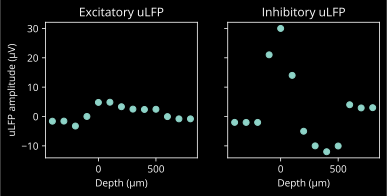

In [2]:

def read_data(fname):
    with open(fname) as csvfile:
        r = csv.reader(csvfile)
        rows = []
        for row in r:
            rows.append(row)
        return np.array(rows, dtype=float)

def clean_data(depth_amp, table_amp_values):
    depth_amp = np.vstack((depth_amp, [800, 0]))
    depth_amp[:, 0] = np.around(depth_amp[:, 0], -1)
    depth_amp[[0, 4, 8, 12], 1] = table_amp_values
    return depth_amp

exc_depth_amp = read_data('../web-plot-digitizer/fig5a-points.csv')
exc_depth_amp = clean_data(exc_depth_amp, [-1.6, 4.8, 2.4, -0.8])

inh_depth_amp = read_data('../web-plot-digitizer/fig5b-points.csv')
inh_depth_amp = clean_data(inh_depth_amp, [-2, 30, -12, 3])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6, 2.5))
axs[0].scatter(exc_depth_amp[:, 0], exc_depth_amp[:, 1])
axs[0].set(title='Excitatory uLFP', ylabel='uLFP amplitude (μV)', xlabel='Depth (μm)')
axs[1].scatter(inh_depth_amp[:, 0], inh_depth_amp[:, 1])
axs[1].set(title='Inhibitory uLFP', xlabel='Depth (μm)')
plt.show()

## Some modifications
The amplitude values in the figure are 10 times what is recommended in table 1, so we will scale them down.

To make the profile more flexible, we'll also interpolate and extrapolate, assuming that by 200 μm outside the reported range the uLFP drops to 0.

Finally, we'll change from μm to mm for consistency with horizontal coordinates.

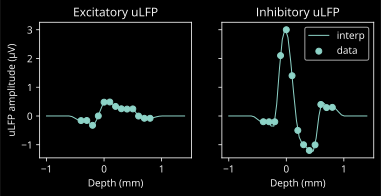

In [3]:
from scipy.interpolate import interp1d
def modify_and_interpolate_data(data):
    data_mod = data.copy()
    data_mod[:, 1] /= 10
    npad = 10  # adding multiple zeros will prevent spline interp overshoot
    deep_padding = np.zeros((npad, 2))
    deep_padding[:, 0] = np.linspace(-700, -600, npad)
    sup_padding = np.zeros((npad, 2))
    sup_padding[:, 0] = np.linspace(1000, 1100, npad)
    data_mod = np.vstack([deep_padding, data_mod, sup_padding])
    data_mod[:, 0] /= 1000
    return interp1d(data_mod[:, 0], data_mod[:, 1], kind='cubic', 
                    fill_value=0, bounds_error=False)

f_exc = modify_and_interpolate_data(exc_depth_amp)
f_inh = modify_and_interpolate_data(inh_depth_amp)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6, 2.5))
depths = np.linspace(-1, 1.4)
axs[0].scatter(exc_depth_amp[:, 0]/1000, exc_depth_amp[:, 1]/10)
axs[0].set(title='Excitatory uLFP', ylabel='uLFP amplitude (μV)', xlabel='Depth (mm)')
axs[0].plot(depths, f_exc(depths), lw=1)
axs[1].scatter(inh_depth_amp[:, 0]/1000, inh_depth_amp[:, 1]/10, label='data')
axs[1].set(title='Inhibitory uLFP', xlabel='Depth (mm)')
axs[1].plot(depths, f_inh(depths), lw=1, label='interp')
axs[1].legend()
plt.show()

This looks reasonable. Now let's save the interpolation objects:

In [4]:
import pickle
with open('../tklfp/exc_A0_by_depth.pkl', 'wb') as exc_file, open('../tklfp/inh_A0_by_depth.pkl', 'wb') as inh_file:
    pickle.dump(f_exc, exc_file)
    pickle.dump(f_inh, inh_file)